In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

Links of websites with climatic data (to be scraped)

In [2]:
# Greenwich Park, Hampstead, Hampton, Heathrow, Kew Gardens, Northolt, Northwood 
links = ['https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-climate-averages/u10hb54gm',
         'https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-climate-averages/gcpv7fnqu',
         'https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-climate-averages/gcpsrrk8m',
         'https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-climate-averages/gcpsvg3nc',
         'https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-climate-averages/gcpuckhb6',
         'https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-climate-averages/gcptq81bc',
         'https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-climate-averages/gcptwusdp']
Temperatures =  pd.DataFrame(data=[], columns=['Min_T', 'Max_T', 'Latitude', 'Longitude', 'Altitude'])
Temperatures

,Min_T,Max_T,Latitude,Longitude,Altitude


A loop to web-scrape the 7 links.

In [3]:
for i in links:
    # web scraping
    website_url = requests.get(i).text
    soup = BeautifulSoup(website_url,'lxml')
    My_table = soup.find('table',{'class':'table alternate-bg'})
    df = pd.read_html(str(My_table))[0]
    
    # choose min and max T
    df_Tmaxmin = df[['Month','Maximum temperature (°C)','Minimum temperature (°C)']]
    df_summer = df_Tmaxmin.loc[5:7]
    Max_T = df_summer['Maximum temperature (°C)'].mean()
    Min_T = df_summer['Minimum temperature (°C)'].mean()
    
    # get longitude, latitude and altitude
    pokus = soup.body.find_all('span')
    latloc = str(pokus[24])[6:-7]
    carka_mez = (latloc.find(','))+2
    altid = str(pokus[25])[6:]
    delitko = altid.find('above')
    tobelat = float(latloc[:(carka_mez-2)])
    tobelon = float(latloc[carka_mez:])
    tobealt = float(altid[:delitko-3])
    
    # append data to dataframe
    df_tobe = pd.DataFrame({'Min_T': [Min_T], 'Max_T': [Max_T], 'Latitude': [tobelat], 'Longitude': [tobelon], 'Altitude':[tobealt]})
    Temperatures = Temperatures.append(df_tobe)

Final corrections of the dataframe

In [4]:
# A list of station names to be added
stations = ['Greenwich Park', 'Hampstead', 'Hampton', 'Heathrow', 'Kew Gardens', 'Northolt', 'Northwood'] 
Temperatures['Stations'] = stations

Temperatures = Temperatures.reset_index()
Temperatures.drop(Temperatures.columns[0], axis = 1, inplace = True)
Temperatures

,Min_T,Max_T,Latitude,Longitude,Altitude,Stations
0,13.100000,22.500000,51.47700,0.0040,47.0,Greenwich Park
1,12.400000,21.433333,51.56000,-0.1780,137.0,Hampstead
2,13.066667,21.933333,51.41194,-0.3781,12.0,Hampton
3,13.100000,22.566667,51.47900,-0.4490,25.0,Heathrow
4,12.166667,22.566667,51.48200,-0.2900,6.0,Kew Gardens
5,12.333333,22.300000,51.54800,-0.4150,40.0,Northolt
6,12.266667,21.600000,51.61690,-0.4000,113.0,Northwood


Find number of green spaces around each station.

In [5]:
# CREDENTIALS
# THE CREDENTIALS WERE REMOVED IN ORDER NOT TO BE ABUSED
VERSION = '20180605'

from pandas.io.json import json_normalize


In [6]:
#Function to find number of parks or gardens in a given radius of a climatic station
def getNearbyVenues(latitudes, longitudes, category, search_query, radius, LIMIT):
    
    count=[]
    for lat, lng in zip(latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, category, LIMIT)

            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        dataframe = json_normalize(results)
        dataframe.shape[0]
        
        # return only relevant information for each nearby venue
        count.append(dataframe.shape[0])
                    
    return(count)      

In [7]:
# Use the function for parks and gardens for 1km, 5km and 10km radiuses
# Venue categories come from: https://developer.foursquare.com/docs/resources/categories

london_parks_1km = getNearbyVenues(latitudes=Temperatures['Latitude'], longitudes=Temperatures['Longitude'], category = '4bf58dd8d48988d163941735',
                                 search_query = 'park', radius = 1000, LIMIT = 500)
london_parks_5km = getNearbyVenues(latitudes=Temperatures['Latitude'], longitudes=Temperatures['Longitude'], category = '4bf58dd8d48988d163941735',
                                 search_query = 'park', radius = 5000, LIMIT = 500)
london_parks_10km = getNearbyVenues(latitudes=Temperatures['Latitude'], longitudes=Temperatures['Longitude'], category = '4bf58dd8d48988d163941735',
                                 search_query = 'park', radius = 10000, LIMIT = 500)

london_gardens_1km = getNearbyVenues(latitudes=Temperatures['Latitude'], longitudes=Temperatures['Longitude'], category = '4bf58dd8d48988d15a941735',
                                 search_query = 'garden', radius = 1000, LIMIT = 500)
london_gardens_5km = getNearbyVenues(latitudes=Temperatures['Latitude'], longitudes=Temperatures['Longitude'], category = '4bf58dd8d48988d15a941735',
                                 search_query = 'garden', radius = 5000, LIMIT = 500)
london_gardens_10km = getNearbyVenues(latitudes=Temperatures['Latitude'], longitudes=Temperatures['Longitude'], category = '4bf58dd8d48988d15a941735',
                                 search_query = 'garden', radius = 10000, LIMIT = 500)


In [8]:
# Assign the numbers of gardens/parks to original dataframe
Temperatures = Temperatures.assign(parks_1km = london_parks_1km, parks_5km = london_parks_5km, parks_10km = london_parks_10km,
                   gardens_1km = london_gardens_1km, gardens_5km = london_gardens_5km, gardens_10km = london_gardens_10km )

# Make also total sum of green spaces around each climate station
Temperatures['total_gs_1km'] = Temperatures['parks_1km'] + Temperatures['gardens_1km']
Temperatures['total_gs_5km'] = Temperatures['parks_5km'] + Temperatures['gardens_5km']
Temperatures['total_gs_10km'] = Temperatures['parks_10km'] + Temperatures['gardens_10km']

In [9]:
Temperatures

,Min_T,Max_T,Latitude,Longitude,Altitude,Stations,parks_1km,parks_5km,parks_10km,gardens_1km,gardens_5km,gardens_10km,total_gs_1km,total_gs_5km,total_gs_10km
0,13.100000,22.500000,51.47700,0.0040,47.0,Greenwich Park,3,50,50,8,46,50,11,96,100
1,12.400000,21.433333,51.56000,-0.1780,137.0,Hampstead,3,50,50,3,50,50,6,100,100
2,13.066667,21.933333,51.41194,-0.3781,12.0,Hampton,1,45,50,2,24,50,3,69,100
3,13.100000,22.566667,51.47900,-0.4490,25.0,Heathrow,1,34,50,0,1,50,1,35,100
4,12.166667,22.566667,51.48200,-0.2900,6.0,Kew Gardens,4,50,50,6,50,50,10,100,100
5,12.333333,22.300000,51.54800,-0.4150,40.0,Northolt,0,50,50,1,5,40,1,55,90
6,12.266667,21.600000,51.61690,-0.4000,113.0,Northwood,0,27,50,2,8,23,2,35,73


In [10]:
# The variable "parks_10km" has the same value for all stations.
# Therefore, it can hardly be a predictor and we can drop it.
Temperatures.drop(['parks_10km'], axis=1, inplace = True)

In [11]:
# Correlation matrix
round(Temperatures.corr(),2)

,Min_T,Max_T,Latitude,Longitude,Altitude,parks_1km,parks_5km,gardens_1km,gardens_5km,gardens_10km,total_gs_1km,total_gs_5km,total_gs_10km
Min_T,1.00,0.32,-0.69,0.18,-0.37,-0.06,-0.05,0.01,-0.12,0.48,-0.02,-0.11,0.48
Max_T,0.32,1.00,-0.53,0.03,-0.82,0.22,0.23,0.28,-0.05,0.43,0.27,0.03,0.43
Latitude,-0.69,-0.53,1.00,-0.11,0.79,-0.30,-0.37,-0.21,-0.21,-0.77,-0.26,-0.28,-0.77
Longitude,0.18,0.03,-0.11,1.00,0.22,0.70,0.55,0.86,0.80,0.38,0.85,0.78,0.38
Altitude,-0.37,-0.82,0.79,0.22,1.00,-0.08,-0.23,-0.09,0.11,-0.46,-0.09,0.01,-0.46
parks_1km,-0.06,0.22,-0.30,0.70,-0.08,1.00,0.60,0.78,0.93,0.64,0.90,0.89,0.64
parks_5km,-0.05,0.23,-0.37,0.55,-0.23,0.60,1.00,0.51,0.67,0.67,0.57,0.83,0.67
gardens_1km,0.01,0.28,-0.21,0.86,-0.09,0.78,0.51,1.00,0.81,0.30,0.97,0.78,0.30
gardens_5km,-0.12,-0.05,-0.21,0.80,0.11,0.93,0.67,0.81,1.00,0.52,0.90,0.97,0.52
gardens_10km,0.48,0.43,-0.77,0.38,-0.46,0.64,0.67,0.30,0.52,1.00,0.44,0.61,1.00


Let´s make scatter plots to examine types of relationships.

In [12]:
# Some important modules and variables
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Feature set of predictors
Features = Temperatures[['Latitude', 'Altitude', 'gardens_5km', 'gardens_10km']]
Features = Features.rename(columns={"gardens_5km": "Gardens within 5 km", "gardens_10km": "Gardens within 10 km"})

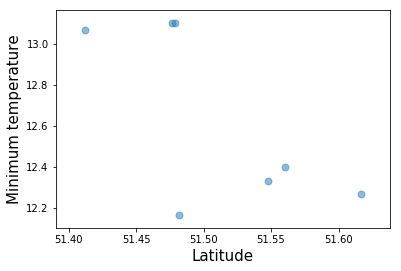

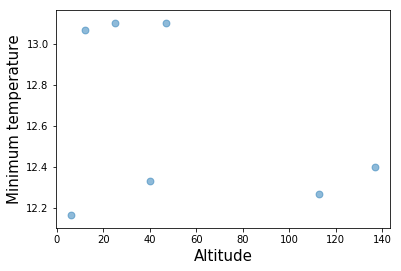

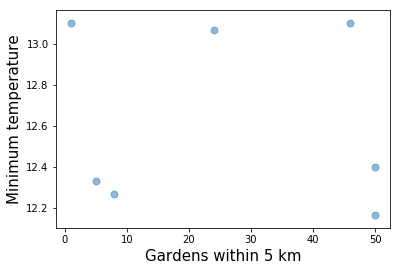

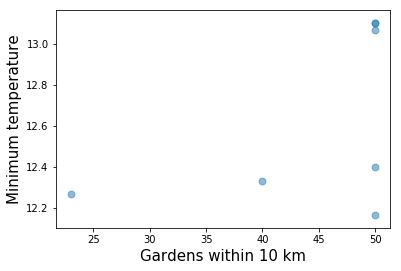

In [13]:
# Loop for minimum temperature
for column in Features:
    plt.scatter(Features[column], Temperatures.Min_T, s=np.pi*15, alpha=0.5)
    plt.ylabel('Minimum temperature', fontsize = 15)
    plt.xlabel((Features[column].name), fontsize = 15)
    plt.show()

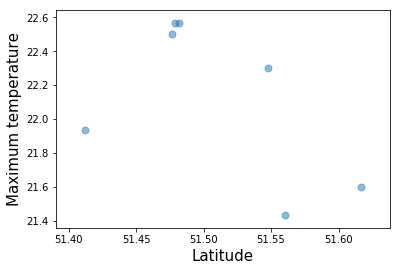

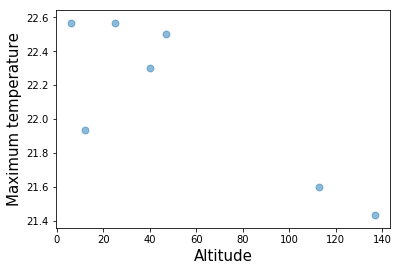

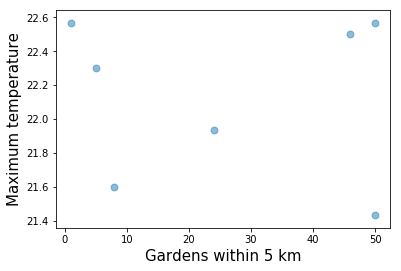

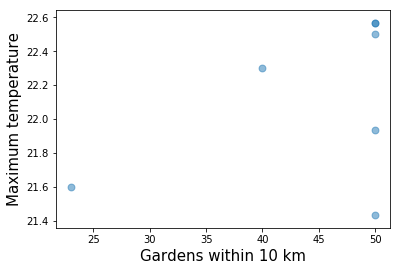

In [14]:
# Loop for maximum temperature
for column in Features:
    plt.scatter(Features[column], Temperatures.Max_T, s=np.pi*15, alpha=0.5)
    plt.ylabel('Maximum temperature', fontsize = 15)
    plt.xlabel((Features[column].name), fontsize=15)
    plt.show()
    

In each case it did not seem that any other than linear regression would yield better results.
Let´s try simple linear regression for several variables.

In [15]:
#Load module for linear regression 
from sklearn.linear_model import LinearRegression

In [16]:
# Function for linear regression
def LM_function(Features, min_max):
    LM_df = pd.DataFrame(data=[], columns=['Intercept', 'Slope', 'R2'])
    for column in Features:
        #Create linear regression object
        lm = LinearRegression()
        #Choose input data
        X = Features[[column]]
        Y = min_max
        #Fit the model
        lm.fit(X,Y)
        intercept = round(lm.intercept_[0],4)
        coef = round(lm.coef_[0][0],4)
        R2 = round(lm.score(X,Y),4)
        #Intercept, slope, R2 and append data to dataframe
        df_tobe = pd.DataFrame({'Intercept':[intercept], 'Slope':[coef], 'R2':[R2] })
        LM_df = LM_df.append(df_tobe)
    LM_df['Predictor'] = ['Latitude', 'Altitude', 'Gardens within 5 km', 'Gardens within 10 km']
    LM_df = LM_df[['Predictor', 'Intercept', 'Slope', 'R2']]
    return(LM_df)

In [17]:
# Function used for minimum and maximum temperature
LM_Min_T = LM_function(Features = Features, min_max = Temperatures[['Max_T']])
LM_Max_T = LM_function(Features = Features, min_max = Temperatures[['Min_T']])

In [18]:
# Function used for maximum temperature
LM_Max_T

,Predictor,Intercept,Slope,R2
0,Latitude,237.7188,-4.3697,0.4743
0,Altitude,12.8061,-0.0032,0.1404
0,Gardens within 5 km,12.6967,-0.0024,0.0153
0,Gardens within 10 km,11.7227,0.0204,0.2346


In [19]:
# Function used for minimum temperature
LM_Min_T

,Predictor,Intercept,Slope,R2
0,Latitude,214.1716,-3.7282,0.2860
0,Altitude,22.5462,-0.0077,0.6795
0,Gardens within 5 km,22.1588,-0.0012,0.0029
0,Gardens within 10 km,21.2422,0.0198,0.1841


Let´s now try multiple linear regression.

In [20]:
# Dataframe for results
MLR_results = pd.DataFrame(data=[], columns=['Temperature','Intercept', 'Slope_lat','Slope_alt', 'Slope_g5km', 'Slope_g10km', 'R2'])

In [21]:
# Function for multiple linear regression with four features
def MLR4_function(Features, min_max, whichT):
    X = Features
    Y = min_max
    lm = LinearRegression()
    lm.fit(X,Y)

    intercept = round(lm.intercept_[0],4)
    coef_lat = round(lm.coef_[0][0],4)
    coef_alt = round(lm.coef_[0][1],4)
    coef_g5km = round(lm.coef_[0][2],4)
    coef_g10km = round(lm.coef_[0][3],4)
    R2 = round(lm.score(X,Y),4)

    df_tobe = pd.DataFrame({'Temperature':whichT, 'Intercept':[intercept], 'Slope_lat':[coef_lat], 'Slope_alt':[coef_alt], 'Slope_g5km':[coef_g5km], 'Slope_g10km':[coef_g10km], 'R2':[R2] })
    return(df_tobe)

In [22]:
# Function used for minimum and maximum temperature
MLR_Max_T = MLR4_function(Features = Features, min_max = Temperatures[['Max_T']], whichT = 'Maximum temperature')
MLR_Min_T = MLR4_function(Features = Features, min_max = Temperatures[['Min_T']], whichT = 'Minimum temperature')

In [23]:
# Connect the results into one dataframe
MLR_results = MLR_results.append(MLR_Max_T)
MLR_results = MLR_results.append(MLR_Min_T)
MLR_results

,Temperature,Intercept,Slope_lat,Slope_alt,Slope_g5km,Slope_g10km,R2
0,Maximum temperature,-308.8022,6.4159,-0.0122,0.0001,0.0247,0.8171
0,Minimum temperature,488.8560,-9.2486,0.0073,-0.0105,0.0013,0.7641


Now let´s try if R2 is much lower only with latitude and altitude combined.

In [24]:
# Dataframe for results
MLR2_results = pd.DataFrame(data=[], columns=['Temperature','Intercept', 'Slope_lat','Slope_alt', 'R2'])

# Dataframe with latitude and altitude
Lat_alt = Temperatures[['Latitude', 'Altitude']]

# Function for multiple linear regression with two features
def MLR2_function(Features, min_max, whichT):
    X = Features
    Y = min_max
    lm = LinearRegression()
    lm.fit(X,Y)

    intercept = round(lm.intercept_[0],4)
    coef_lat = round(lm.coef_[0][0],4)
    coef_alt = round(lm.coef_[0][1],4)
    R2 = round(lm.score(X,Y),4)

    df_tobe = pd.DataFrame({'Temperature':whichT, 'Intercept':[intercept], 'Slope_lat':[coef_lat], 'Slope_alt':[coef_alt], 'R2':[R2] })
    return(df_tobe)

In [25]:
# Function used for minimum and maximum temperature
MLR2_Max_T = MLR2_function(Features = Lat_alt, min_max = Temperatures[['Max_T']], whichT = 'Maximum temperature')
MLR2_Min_T = MLR2_function(Features = Lat_alt, min_max = Temperatures[['Min_T']], whichT = 'Minimum temperature')

# Connect the results into one dataframe
MLR2_results = MLR2_results.append(MLR2_Max_T)
MLR2_results = MLR2_results.append(MLR2_Min_T)
MLR2_results

,Temperature,Intercept,Slope_lat,Slope_alt,R2
0,Maximum temperature,-94.7177,2.2791,-0.0101,0.7189
0,Minimum temperature,359.3077,-6.7343,0.0040,0.5552
